In [3]:
!pip install transformers
!pip install fastai==2.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re

In [6]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
text = """ 옛날 옛날 어느 마을에 흥부와 놀부 형제가 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

옛날 옛날 어느 마을에 흥부와 놀부 형제가 왁자지껄 떠들어대며 "우리 집엔 왜 이렇게 많은 사람들이 모여 사는 거야?" 하고 묻는다.
그런데 그 마을 사람들은 모두 다들 자기네 동네에 살고 있는 사람들이라고 한다.
이렇게 해서 우리 마을은 '흥부가 살던 곳'이라는 뜻의 '고향'이 되었다.
그리고 이 고향은 바로 지금의 서울 종로구 숭인동이다.
숭인동은 원래 종로에서 가장 오래된 주택가였다.
1970년대까지만 해도 이곳은 재개발로 인해 헐리고 빈집이 많아졌다.
하지만 1980년대 들어 다시 활기를 되찾기 시작했다.
당시만 하더라도 이곳에는 낡은 건물들이 많이 남아 있었다.
그러나 1990년대 들어서부터는 예전의


In [ ]:
with open('/content/drive/MyDrive/음성인식_4조 (1)/transformer/시 사랑-67p까지.csv') as f:
   lines = f.read()
lines=" ".join(lines.split())

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

In [ ]:
fastai

<module 'fastai' from '/usr/local/lib/python3.7/dist-packages/fastai/__init__.py'>

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)


epoch,train_loss,valid_loss,perplexity,time
0,7.299284,7.761359,2348.092773,00:32


epoch,train_loss,valid_loss,perplexity,time
0,7.009048,6.938381,1031.099243,00:32
1,6.415027,6.614388,745.748169,00:33
2,5.841978,6.643199,767.546448,00:33
3,5.328120,6.638115,763.654480,00:33
4,4.790914,6.638954,764.294861,00:33
5,4.466107,6.666509,785.648254,00:33


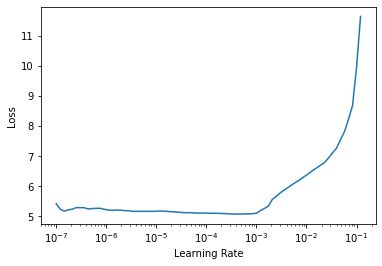

In [ ]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(6)

In [ ]:
prompt=" 옛날 옛날 어느 마을에 흥부와 놀부 형제가 "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'옛날 옛날 어느 마을에 흥부와 놀부 형제가 봤다 이기고 싶습니다,오보영),"바 : 목련이석구상(驚蟄) / 박얼서 "<詩와우리걸음이> 오언절구 [형식] 文目: 칠언검다리. (202108 ** ‘七十5) 不肖子[穀水頸]의 우수(二口(운’차래지능)와 버들개구리 짝을 다녀온 모양,漢녀’고? ‘자금머리’로 비유)’의 경지)가 합쳐지는 또면 간다. 처녀가고는 아직도 두물머리를 한눈에 볼 수 없는 소리가 부러'